In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import sys
# Load custom functions
sys.path.append('../code')
from interpolation import cfl_interpolation5
from diusst_funcs import make_mesh
from diusst_model5 import diusst_bayesian as diusst
sys.path.append('../data/bayesian_training/')

In [8]:
# Fit parameters
param_names = ['kappa', 'mu', 'attenu', 'kappa0', 'lambd']

# Parameter limits
param_min = np.array([0, 0, 1e-3, 0.5, 3])
param_max = np.array([4e-4, 0.1, 10, 1., 10])

# Initial walker positions
param_start = np.array([1e-4, 1e-3, 2.5, 0.805, 3])

# Sampling
nwalkers = 32
nsteps = 2000

# DIUSST model
scheme = 'euler'
z_f = 10
dz0 = 0.10
ngrid = 40
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

# Dataset
data_path = '../data/bayesian_training/'
data_filename = 'training_minnett_err-boatspd-radio_humid10.csv'
data_interval1 = [96,413]
data_interval2 = [1290,1585]

print(make_mesh(dz0,ngrid,z_f=z_f)[1])

1.04215539432737


In [11]:
# Load dataset
data_orig1 = pd.read_csv(data_path+data_filename)[data_interval1[0]:data_interval1[1]]
data_orig2 = pd.read_csv(data_path+data_filename)[data_interval2[0]:data_interval2[1]]

# interpolate to meet CFL condition
timer = time.time()
data1, dtlist1, idxlist1 = cfl_interpolation5(data_orig1, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=param_max[0], k_0_max=0.5, lambd_min=param_min[-1],
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=True)
print(time.time()-timer)

data2, dtlist2, idxlist2 = cfl_interpolation5(data_orig2, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=param_max[0], k_0_max=param_min[3], lambd_min=param_min[-1],
        maxwind=maxwind, z_f=z_f,
        save=None,verbose=True)

# extract data from dataset 1
ftemp1 = np.mean(data_orig1['ftemp'].to_numpy(np.float64))

times1 = data1['times'].to_numpy(np.float64)
wind1 = data1['wind'].to_numpy(np.float64)
swrad1 = data1['swrad'].to_numpy(np.float64)
humid1 = data1['humid'].to_numpy(np.float64)
atemp_rel1 = data1['atemp'].to_numpy(np.float64) - data1['ftemp'].to_numpy(np.float64) + ftemp1

times_orig1 = data_orig1['times'].to_numpy(np.float64)
sst_data1 = data_orig1['sst'].to_numpy(np.float64) - data_orig1['ftemp'].to_numpy(np.float64) + ftemp1
sst_err1 = data_orig1['sst_err'].to_numpy(np.float64)

# extract data from dataset 2
ftemp2 = np.mean(data_orig2['ftemp'].to_numpy(np.float64))

times2 = data2['times'].to_numpy(np.float64)
wind2 = data2['wind'].to_numpy(np.float64)
swrad2 = data2['swrad'].to_numpy(np.float64)
humid2 = data2['humid'].to_numpy(np.float64)
atemp_rel2 = data2['atemp'].to_numpy(np.float64) - data2['ftemp'].to_numpy(np.float64) + ftemp2

times_orig2 = data_orig2['times'].to_numpy(np.float64)
sst_data2 = data_orig2['sst'].to_numpy(np.float64) - data_orig2['ftemp'].to_numpy(np.float64) + ftemp2
sst_err2 = data_orig2['sst_err'].to_numpy(np.float64)
print(time.time()-timer)

+++ Variable time-step interpolation +++
Interpolated dataset has 349739 time steps with average length 1.146 s.
Constant dt interpolation would require dt = 0.276 s --> 926967 steps.
Computation time will be reduced by 62.271 %
++++++++++++++++++++++++++++++++++++++++
0.502234697341919
+++ Variable time-step interpolation +++
Interpolated dataset has 194429 time steps with average length 3.354 s.
Constant dt interpolation would require dt = 0.329 s --> 820438 steps.
Computation time will be reduced by 76.302 %
++++++++++++++++++++++++++++++++++++++++
0.7256255149841309


In [23]:
# Define likelihood function
def bayesian_likelihood(params):
    kappa, mu, attenu, kappa0, lambd = params
    simu1 = diusst(
            times1, atemp_rel1, swrad1, u_data=wind1, sa_data=humid1, T_f=ftemp1,
            k_eddy=kappa, mu=mu, attenu=attenu, k_0=kappa0, lambd=lambd,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)
    simu2 = diusst(
            times2, atemp_rel2, swrad2, u_data=wind2, sa_data=humid2, T_f=ftemp2,
            k_eddy=kappa, mu=mu, attenu=attenu, k_0=kappa0, lambd=lambd,
            opac=opac, k_mol=k_mol,
            dz=dz0, ngrid=ngrid)
    sst_model1, sst_model2 = simu1[:,0], simu2[:,0]
    mse = np.sum(((sst_model1[idxlist1] - sst_data1[:-1])**2/sst_err1[:-1])**2) + np.sum(((sst_model2[idxlist2] - sst_data2[:-1])**2/sst_err2[:-1])**2)
    return mse, simu1, simu2

# Define posterior distribution function
def log_prob(x):
    if (x<param_min).any() or (x>param_max).any():
        return -np.inf
    else:
        mse, simu1, simu2 = bayesian_likelihood(x)
        logprob = - (mse + np.log( np.prod(param_max-param_min) ))
        if np.isnan(logprob):
            print('====> ERROR: Simulation did not converge! Overflow or other problem!!! <====')
        return logprob, simu1, simu2

In [24]:
par1 = [3e-4,0.01,8,0.5,3]
par2 = [2e-4,0.005,4,0.8,2]
par3 = [1e-4,0.005,3,0.8,2]
par4 = [1e-4,0.005,4,0.8,10]
par5 = [1e-4,0.005,4,0.8,2]

In [25]:
timer = time.time()
res1 = log_prob(par1)
print(time.time()-timer)
#res2 = log_prob(par2)
#res3 = log_prob(par3)
#res4 = log_prob(par4)
#res5 = log_prob(par5)

15.23273754119873


In [31]:
-213457654533456654.232355745

-2.1345765453345664e+17

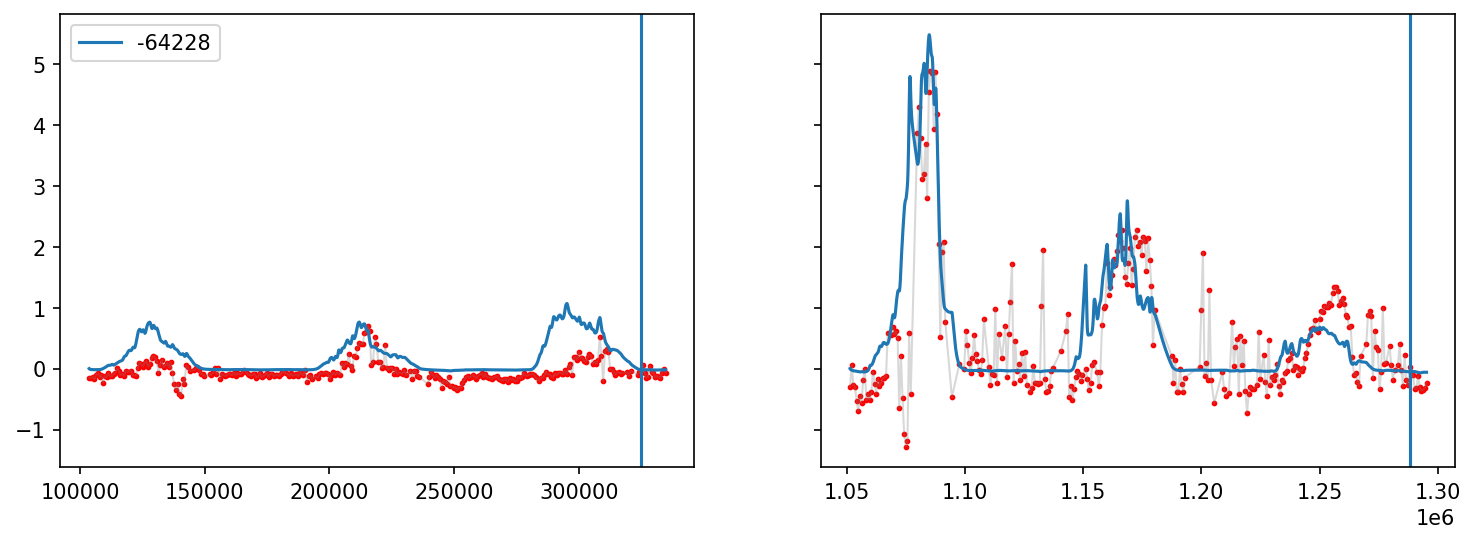

In [169]:
fig, ax = plt.subplots(1,2,dpi=150,figsize=(12,4),sharey=True)
ax[0].plot(times_orig1,sst_data1-ftemp1,lw=1,c='gray',alpha=0.3)
ax[0].scatter(times_orig1,sst_data1-ftemp1,s=3,c='red')
ax[1].plot(times_orig2,sst_data2-ftemp2,lw=1,c='gray',alpha=0.3)
ax[1].scatter(times_orig2,sst_data2-ftemp2,s=3,c='red')

ax[0].plot(times1,res1[1][0][:,0]-ftemp1,label=round(res1[0]))
ax[1].plot(times2,res1[2][0][:,0]-ftemp2)
ax[0].legend()

ax[1].axvline(x=times_orig2[-11])
ax[0].axvline(x=times_orig1[-15])

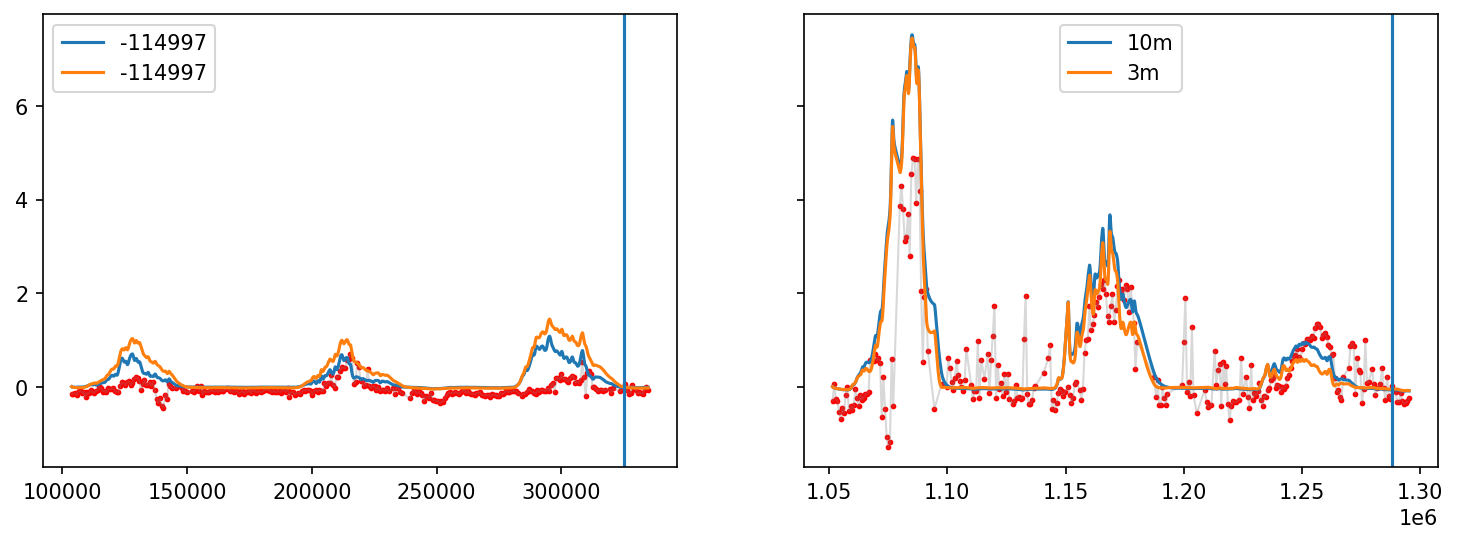

In [157]:
fig, ax = plt.subplots(1,2,dpi=150,figsize=(12,4),sharey=True)
ax[0].plot(times_orig1,sst_data1-ftemp1,lw=1,c='gray',alpha=0.3)
ax[0].scatter(times_orig1,sst_data1-ftemp1,s=3,c='red')
ax[1].plot(times_orig2,sst_data2-ftemp2,lw=1,c='gray',alpha=0.3)
ax[1].scatter(times_orig2,sst_data2-ftemp2,s=3,c='red')

ax[0].plot(times1,res1[1][0][:,0]-res1[1][0][:,21],label=round(res1[0]))
ax[0].plot(times1,res1[1][0][:,0]-ftemp1,label=round(res1[0]))


ax[1].plot(times2,res1[2][0][:,0]-ftemp2,label='10m')
ax[1].plot(times2,res1[2][0][:,0]-res1[2][0][:,21],label='3m')
#ax[1].plot(times2,res1[2][0][:,21]-ftemp2)
ax[0].legend()
ax[1].legend()

ax[1].axvline(x=times_orig2[-11])
ax[0].axvline(x=times_orig1[-15])

In [26]:
make_mesh(dz0,ngrid,z_f=z_f)[0][21]

-3.0452936687931453

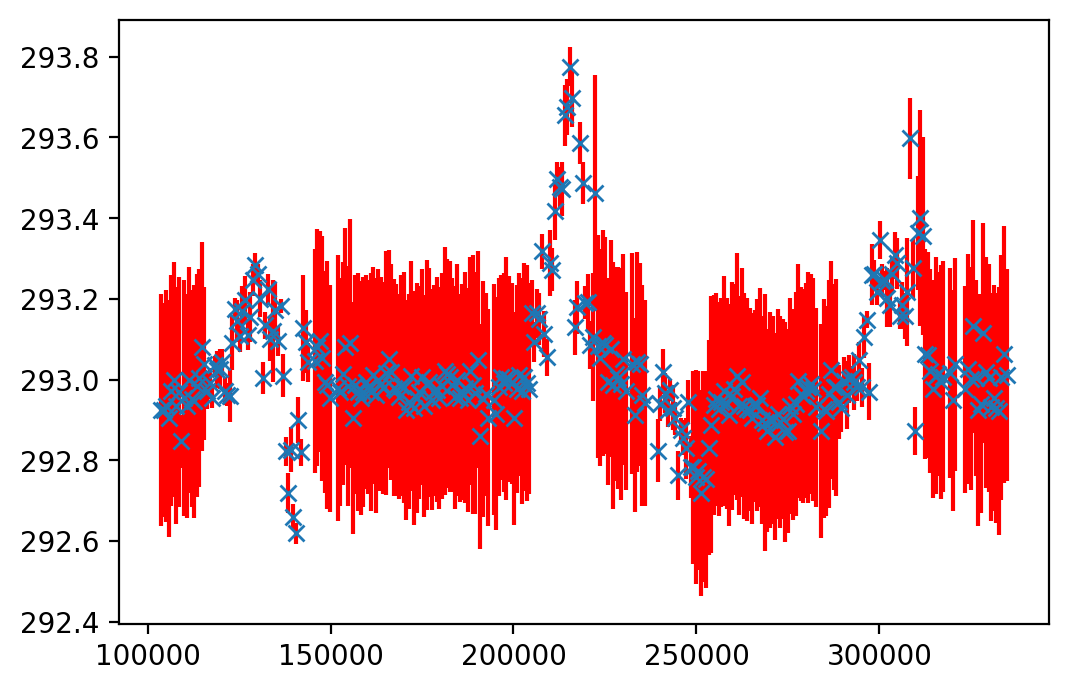

In [95]:
fig, ax = plt.subplots(dpi=200)
ax.errorbar(times_orig1,sst_data1,yerr=sst_err1,fmt='x',ecolor='red')
plt.show()

In [127]:
a = 0
timer = time.time()
if a == 1:
    print('blablbalbalba')
print(time.time()-timer)

0.00029969215393066406


In [12]:
data_orig1

,times,sst,sst_err,ftemp,wind,atemp,swrad,humid,boatspd
96,103693.92,292.689,0.287466,292.839,6.084,291.927,0.6,0.01,11.8
97,104397.60,292.779,0.264247,292.929,6.946,291.927,0.7,0.01,11.4
98,105092.40,292.784,0.286411,292.924,6.890,291.942,0.6,0.01,11.7
99,105787.44,292.690,0.292575,292.861,7.170,291.981,0.5,0.01,12.0
100,106482.24,292.705,0.286521,292.807,6.809,292.012,0.5,0.01,11.9
...,...,...,...,...,...,...,...,...,...
408,331953.12,294.594,0.284904,294.738,3.358,294.660,0.5,0.01,12.6
409,332651.76,294.527,0.307685,294.679,4.214,294.665,0.5,0.01,12.2
410,333350.40,294.973,0.302795,295.042,5.591,294.916,0.5,0.01,12.4
411,334049.52,295.267,0.318959,295.279,6.126,295.163,0.5,0.01,12.7


In [19]:
round(make_mesh(0.1,40,z_f=10)[0][21],3)

-3.045

In [33]:
np.log( np.prod(param_max-param_min))

-6.571383047361257